In [1]:
!pip install -r requirements.txt

Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic/aiohappyeyeballs-2.6.1+computecanada-py3-none-any.whl (from -r requirements.txt (line 1))
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3/aiohttp-3.11.14+computecanada-cp312-cp312-linux_x86_64.whl (from -r requirements.txt (line 2))
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic/aiosignal-1.3.2+computecanada-py2.py3-none-any.whl (from -r requirements.txt (line 3))
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic/beautifulsoup4-4.13.3+computecanada-py3-none-any.whl (from -r requirements.txt (line 11))
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic/filelock-3.18.0+computecanada-

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import Dinov2Model, SegformerForSemanticSegmentation
from safetensors.torch import load_file
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.checkpoint import checkpoint as torch_checkpoint
from torchmetrics import MeanMetric
from PIL import Image
import os
import numpy as np
from dataclasses import dataclass
import random
from tqdm import tqdm
import time
import wandb

In [2]:
# wandb.login(key="4f8dccbaced16f201316dd4113139739694dfd3b") 

In [3]:
# wandb.init(project="joint-training",
#           name="joint_training_guide_Top2")

In [3]:
# ----------------------------
# Model Definitions
# ----------------------------

class SimCLR(nn.Module):
    def __init__(self, dropout_p=0.5, embedding_size=128, linear_eval=False):
        super().__init__()
        self.linear_eval = linear_eval
        self.dropout_p = dropout_p
        self.embedding_size = embedding_size
        self.encoder = Dinov2Model.from_pretrained('microsoft/rad-dino')
        
        for name, param in self.encoder.named_parameters():
            # Freeze everything by default
            param.requires_grad = False

        for name, param in self.encoder.named_parameters():
            # Unfreeze the last block and the final layernorm:
            if "encoder.layer.11" in name or "layernorm" in name:
                param.requires_grad = True

        self.projection = nn.Sequential(
            nn.Linear(768, 256),
            nn.Dropout(p=self.dropout_p),
            nn.ReLU(),
            nn.Linear(256, embedding_size)
        )

    def forward(self, x):
        if not self.linear_eval:
            x = torch.cat(x, dim=0)
        outputs = self.encoder(x)
        encoding = outputs.last_hidden_state[:, 0]
        projection = self.projection(encoding)
        return projection

retrieval_checkpoint = '/home/saahmed/scratch/projects/Image-segmentation/retrieval/checkpoints/simclr_rad-dino_pos-pairs_aug-pairs_epochs100/best_model/'

retrieval_model = SimCLR(dropout_p=0.3, embedding_size=128, linear_eval=True)
encoder_state_dict = load_file(os.path.join(retrieval_checkpoint, 'model.safetensors'))
retrieval_model.encoder.load_state_dict(encoder_state_dict)
projection_state_dict = torch.load(os.path.join(retrieval_checkpoint, 'projection_head.pth'), map_location=torch.device('cpu'))
retrieval_model.projection.load_state_dict(projection_state_dict)

/tmp/ipykernel_2538241/3405643098.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  projection_state_dict = torch.load(os.path.join(retrieval_checkpoint, 'projection_head

<All keys matched successfully>

In [4]:
# class JointSegmentationModel(nn.Module):
#     def __init__(self, base_model, composite_in_channels=7):
#         super().__init__()
#         # Map composite input channels to 3 channels expected by segformer
#         self.input_adapter = nn.Conv2d(composite_in_channels, 3, kernel_size=1)
#         self.base_model = base_model

#     def forward(self, x):
#         x = self.input_adapter(x)
#         outputs = self.base_model(pixel_values=x, return_dict=True)
#         # Upsample logits to match input resolution
#         logits = F.interpolate(outputs["logits"], size=x.shape[-2:], mode="bilinear", align_corners=False)
#         return logits

def dice_coef_loss(predictions, ground_truths, num_classes=4, dims=(1, 2), smooth=1e-8):
    ground_truth_oh = F.one_hot(ground_truths, num_classes=num_classes)
    prediction_norm = F.softmax(predictions, dim=1).permute(0, 2, 3, 1)
    intersection = (prediction_norm * ground_truth_oh).sum(dim=dims)
    summation = prediction_norm.sum(dim=dims) + ground_truth_oh.sum(dim=dims)
    dice = (2.0 * intersection + smooth) / (summation + smooth)
    dice_mean = dice.mean()
    CE = F.cross_entropy(predictions, ground_truths)
    return (1.0 - dice_mean) + CE

In [5]:
def precompute_gallery_embeddings(
    joint_model,
    gallery_images,  # (N, 3, H, W)
    gallery_masks,   # (N, H, W)
    device,
):
    """
    Encodes all gallery images with the retrieval_model once (no extra batch dimension).
    Returns:
        cached_gallery_embeddings: (N, D)  # D = embedding dimension
        cached_gallery_images:     (N, 3, H, W) moved to device
        cached_gallery_masks:      (N, H, W)    moved to device

    NOTE: We wrap this in no_grad() to avoid building a large graph for the gallery.
          That means the gallery side won't backprop on each batch, but the retrieval
          model can still be updated from the query side.
    """
    # Move images/masks to device
    gallery_images = gallery_images.to(device)
    gallery_masks = gallery_masks.to(device)

    N = gallery_images.shape[0]
    gallery_embeddings_list = []

    # print("Calculating Embeddings")
    # start_time = time.time()
    tempbatch_size = 70

    # <-- Turn off gradient tracking for the gallery
    with torch.no_grad():
        for i in range(0, N, tempbatch_size):
            batch = gallery_images[i : i + tempbatch_size]
            # Normal forward pass (no checkpoint, no grad)
            emb = joint_model.retrieval_model(batch)
            gallery_embeddings_list.append(emb)

    # print("Finished Calculating Embeddings")

    # Concatenate chunked embeddings into (N, D)
    cached_gallery_embeddings = torch.cat(gallery_embeddings_list, dim=0)
    # Optionally call .detach() to ensure they have no grad_fn
    cached_gallery_embeddings = cached_gallery_embeddings.detach()

    # end_time = time.time()
    # print(f"Calculating Embeddings Time: {end_time - start_time:.4f} seconds\n")

    return cached_gallery_embeddings, gallery_images, gallery_masks


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

class JointTrainingModule(nn.Module):
    def __init__(self, retrieval_model, segmentation_model, num_classes=4, lr=1e-4,tau=0.1):
        super().__init__()
        self.retrieval_model = retrieval_model
        self.segmentation_model = segmentation_model
        self.lr = lr
        self.num_classes = num_classes
        self.tau = tau  # Temperature for the softmax

        self.cached_gallery_embeddings = None  # shape (N, D)
        self.cached_gallery_images = None     # shape (N, 3, H, W)
        self.cached_gallery_masks = None      # shape (N, H, W)

    def forward(self, query_image):
        """
        query_image:    (B, 3, H, W)
        gallery_images:(B, N, 3, H, W)
        gallery_masks: (B, N, H, W)
        Returns: guide_image, guide_mask
        """
        # -- 1) Compute query embedding
        query_embedding = self.retrieval_model(query_image)

        similarity = F.cosine_similarity(query_embedding.unsqueeze(1), self.cached_gallery_embeddings.unsqueeze(0), dim=-1)

        # -- 2) Get indices and values of the top 2 most similar gallery items
        topk_values, topk_indices = torch.topk(similarity, k=2, dim=-1)

        # -- 3) Calculate softmax weights for the top 2 values
        softmax_weights = F.softmax(topk_values / self.tau, dim=-1)

        # -- 4) Create a zero tensor for the top-k weights
        topk_weights = torch.zeros_like(similarity).float()

        # -- 5) Scatter the softmax weights into the top-k weights at the correct indices
        topk_weights.scatter_(dim=-1, index=topk_indices, src=softmax_weights)

        # -- 6) Weighted sum of the top 2 gallery images and masks
        # guide_image: (B, 3, H, W)
        guide_image = torch.einsum("bn,nchw->bchw", topk_weights, self.cached_gallery_images)
        # guide_mask: (B, H, W)
        guide_mask = torch.einsum("bn,nhw->bhw", topk_weights, self.cached_gallery_masks.float())

        return guide_image, guide_mask

In [7]:
# ----------------------------
# Data Preparation
# ----------------------------
def convert_to_rgb(img):
    return img.convert("RGB")
    
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Lambda(convert_to_rgb),
    transforms.ToTensor(),
])

def remap_labels(target, mapping={0: 0, 85: 1, 170: 2, 255: 3}):
    remapped_target = torch.zeros_like(target, dtype=torch.long)
    for original_label, new_label in mapping.items():
        remapped_target[target == original_label] = new_label
    return remapped_target

# (Paths and file loading logic)
image_dir_ed = '/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/'
mask_dir_ed = '/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/masks/'
image_dir_es = '/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/es/images/'
mask_dir_es = '/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/es/masks/'

image_filenames = sorted([os.path.join(image_dir_ed, i) for i in os.listdir(image_dir_ed)]) + \
                  sorted([os.path.join(image_dir_es, i) for i in os.listdir(image_dir_es)])
mask_filenames = sorted([os.path.join(mask_dir_ed, i) for i in os.listdir(mask_dir_ed)]) + \
                 sorted([os.path.join(mask_dir_es, i) for i in os.listdir(mask_dir_es)])

import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def is_mask_empty(mask):
    return np.all(mask == 255)

valid_images = []
valid_masks = []
for img_path, mask_path in tqdm(zip(image_filenames, mask_filenames), total=len(image_filenames)):
    if not os.path.exists(mask_path):
        continue
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        continue
    if is_mask_empty(mask):
        continue
    valid_images.append(img_path)
    valid_masks.append(mask_path)

print("Total valid image-mask pairs:", len(valid_images))

train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    valid_images, valid_masks, test_size=0.2, random_state=42
)
print("Number of training pairs:", len(train_imgs))
print("Number of validation pairs:", len(val_imgs))

# Prepare guide database (we use a subset for demonstration)
database_images = []
database_masks = []
for img, mask in tqdm(zip(valid_images, valid_masks), total=len(valid_images)):
    g_img = Image.open(img)
    g_mask = Image.open(mask).convert('L')
    processed_img = preprocess(g_img)
    g_mask = g_mask.resize((256,256), resample=Image.NEAREST)
    g_mask = torch.from_numpy(np.array(g_mask)).long()
    g_mask = remap_labels(g_mask)
    database_images.append(processed_img)
    database_masks.append(g_mask)
database_images = torch.stack(database_images, dim=0)
database_masks = torch.stack(database_masks, dim=0)

100%|███████████████████████████████████████████████████████████████████████████████████████| 1902/1902 [00:07<00:00, 262.40it/s]


Total valid image-mask pairs: 1841
Number of training pairs: 1472
Number of validation pairs: 369


100%|███████████████████████████████████████████████████████████████████████████████████████| 1841/1841 [00:14<00:00, 130.04it/s]


In [8]:
db_images = database_images
db_masks = database_masks

In [9]:
class JointMedicalDataset(Dataset):
    def __init__(self, image_file_names, mask_file_names, image_size=(256, 256)):
        self.image_filenames = image_file_names
        self.mask_filenames  = mask_file_names
        self.image_size = image_size

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        query_image_path = self.image_filenames[idx]
        query_mask_path = self.mask_filenames[idx]
        query_image = Image.open(query_image_path)
        query_mask = Image.open(query_mask_path).convert('L')
        query_mask = query_mask.resize(self.image_size, resample=Image.NEAREST)
        query_image = preprocess(query_image)
        query_mask = torch.from_numpy(np.array(query_mask)).long()
        query_mask = remap_labels(query_mask)
        
        return query_image, query_mask

In [10]:
# (Paths and file loading logic)
image_dir_ed_Testing = '/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/'
mask_dir_ed_Testing = '/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/masks/'
image_dir_es_Testing = '/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/es/images/'
mask_dir_es_Testing = '/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/es/masks/'

image_filenames_Testing = sorted([os.path.join(image_dir_ed_Testing, i) for i in os.listdir(image_dir_ed_Testing)]) + \
                  sorted([os.path.join(image_dir_es_Testing, i) for i in os.listdir(image_dir_es_Testing)])
mask_filenames_Testing = sorted([os.path.join(mask_dir_ed_Testing, i) for i in os.listdir(mask_dir_ed_Testing)]) + \
                 sorted([os.path.join(mask_dir_es_Testing, i) for i in os.listdir(mask_dir_es_Testing)])

import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def is_mask_empty(mask):
    return np.all(mask == 255)

valid_images_Testing = []
valid_masks_Testing = []
for img_path, mask_path in tqdm(zip(image_filenames_Testing, mask_filenames_Testing), total=len(image_filenames_Testing)):
    if not os.path.exists(mask_path):
        continue
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        continue
    if is_mask_empty(mask):
        continue
    valid_images_Testing.append(img_path)
    valid_masks_Testing.append(mask_path)

print("Number of Testing pairs:", len(valid_images_Testing))

# Prepare guide database (we use a subset for demonstration)
database_images_Testing = []
database_masks_Testing = []
for img, mask in tqdm(zip(valid_images_Testing, valid_masks_Testing), total=len(valid_images_Testing)):
    g_img = Image.open(img)
    g_mask = Image.open(mask).convert('L')
    processed_img = preprocess(g_img)
    g_mask = g_mask.resize((256,256), resample=Image.NEAREST)
    g_mask = torch.from_numpy(np.array(g_mask)).long()
    g_mask = remap_labels(g_mask)
    database_images_Testing.append(processed_img)
    database_masks_Testing.append(g_mask)
database_images_Testing = torch.stack(database_images_Testing, dim=0)
database_masks_Testing = torch.stack(database_masks_Testing, dim=0)

100%|███████████████████████████████████████████████████████████████████████████████████████| 1076/1076 [00:04<00:00, 252.33it/s]


Number of Testing pairs: 1001


100%|███████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:08<00:00, 119.73it/s]


In [11]:
@dataclass(frozen=True)
class Paths:
    DATA_TRAIN_IMAGES = train_imgs
    DATA_TRAIN_LABELS = train_masks
    
    DATA_VALID_IMAGES = val_imgs
    DATA_VALID_LABELS = val_masks
    
    DATA_TEST_IMAGES = valid_images_Testing
    DATA_TEST_LABELS = valid_masks_Testing
    
    Guide_database_imgs = db_images
    Guide_database_masks = db_masks
    
    Guide_database_imgs_Testing = database_images_Testing
    Guide_database_masks_Testing = database_masks_Testing

# Create datasets and dataloaders
train_ds = JointMedicalDataset(Paths.DATA_TRAIN_IMAGES, Paths.DATA_TRAIN_LABELS,)
valid_ds = JointMedicalDataset(Paths.DATA_VALID_IMAGES, Paths.DATA_VALID_LABELS,)

test_ds = JointMedicalDataset(Paths.DATA_TEST_IMAGES, Paths.DATA_TEST_LABELS,)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_ds, batch_size=4, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False)

In [12]:
import torch.nn as nn
from functools import reduce
import operator as op

def _get_submodule(root, dotted_name):
    """Fetch nested module given a dotted path, e.g. 'encoder.patch_embeddings.0.proj'."""
    return reduce(getattr, dotted_name.split("."), root)

def adapt_segformer_first_conv_to_7ch(segformer_model, copy_rgb_weights=True):
    """
    Makes a SegformerForSemanticSegmentation accept 7‑channel input.

    It hunts for the first Conv2d with in_channels==3 inside
    segformer_model.segformer.encoder, then swaps it for an identical
    Conv2d with in_channels==7.
    """
    # 1️⃣  find the conv
    first_conv_path, old_proj = None, None
    for name, module in segformer_model.segformer.encoder.named_modules():
        if isinstance(module, nn.Conv2d) and module.in_channels == 3:
            first_conv_path, old_proj = name, module
            break
    if old_proj is None:
        raise RuntimeError("Could not locate the first 3‑channel Conv2d inside the encoder!")

    # 2️⃣  build a replacement conv (same hyper‑params, but 7 inputs)
    new_proj = nn.Conv2d(
        in_channels=7,
        out_channels=old_proj.out_channels,
        kernel_size=old_proj.kernel_size,
        stride=old_proj.stride,
        padding=old_proj.padding,
        bias=(old_proj.bias is not None),
    )

    # 3️⃣  copy / init weights
    if copy_rgb_weights:
        with torch.no_grad():
            new_proj.weight[:, :3] = old_proj.weight          # copy RGB
            nn.init.xavier_uniform_(new_proj.weight[:, 3:])   # init extras
            if old_proj.bias is not None:
                new_proj.bias.copy_(old_proj.bias)

    # 4️⃣  drop it into the model
    parent_path = ".".join(first_conv_path.split(".")[:-1])
    attr_name   = first_conv_path.split(".")[-1]
    parent_mod  = _get_submodule(segformer_model.segformer.encoder, parent_path) \
                  if parent_path else segformer_model.segformer.encoder
    setattr(parent_mod, attr_name, new_proj)

    print(f"→ Replaced encoder.{first_conv_path} with 7‑channel conv")
    return segformer_model


In [13]:
ckpt_path = '/scratch/saahmed/projects/Image-segmentation/segmentation/lightning_logs/version_0/checkpoints/ckpt_053-vloss_0.1769_vf1_0.9259.ckpt'
checkpoint   = torch.load(ckpt_path, map_location="cuda:0")
state_dict   = {k.replace("model.", ""): v for k, v in checkpoint["state_dict"].items()}

config       = SegformerForSemanticSegmentation.config_class.from_pretrained(
                   "nvidia/segformer-b4-finetuned-ade-512-512")
config.num_labels = 4                                            # your classes

segformer_base = SegformerForSemanticSegmentation(config)

# ⚠️ load weights *before* we change the conv – ignore the mismatch
missing, unexpected = segformer_base.load_state_dict(state_dict, strict=False)
print("missing:", [m for m in missing if "patch_embed1.proj.weight" in m])

# 🔧 enlarge the first conv to 7‑channels
segformer_base = adapt_segformer_first_conv_to_7ch(segformer_base, copy_rgb_weights=True)

/tmp/ipykernel_2538241/706030494.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint   = torch.load(ckpt_path, map_location="cuda:0")


missing: []
→ Replaced encoder.patch_embeddings.0.proj with 7‑channel conv


In [14]:
# ----------------------------------
# OPTION B – tiny wrapper
# ----------------------------------
class SegFormer7ch(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model          # already 7‑ch

    def forward(self, x):
        out = self.base_model(pixel_values=x, return_dict=True).logits
        # ensure exact spatial match
        if out.shape[-2:] != x.shape[-2:]:
            out = F.interpolate(out, size=x.shape[-2:], mode="bilinear", align_corners=False)
        return out

segmentation_model = SegFormer7ch(segformer_base)

In [15]:
# ----------------------------
# Instantiate Joint Module and Optimizer
# ----------------------------
joint_module = JointTrainingModule(retrieval_model, segmentation_model, num_classes=4, lr=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
joint_module.to(device)

JointTrainingModule(
  (retrieval_model): SimCLR(
    (encoder): Dinov2Model(
      (embeddings): Dinov2Embeddings(
        (patch_embeddings): Dinov2PatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): Dinov2Encoder(
        (layer): ModuleList(
          (0-11): 12 x Dinov2Layer(
            (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (attention): Dinov2SdpaAttention(
              (attention): Dinov2SdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): Dinov2SelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias

In [16]:
optimizer = torch.optim.Adam(joint_module.parameters(), lr=joint_module.lr)

In [17]:
def train_one_epoch(model, dataloader, optimizer, device, scaler):
    model.train()
    running_loss = 0.0

    db_images, db_masks =  Paths.Guide_database_imgs, Paths.Guide_database_masks

    cached_gallery_embeddings, cached_gallery_images, cached_gallery_masks = precompute_gallery_embeddings(
        model,
        db_images,        # Tensor of shape (N, 3, H, W)
        db_masks,         # Tensor of shape (N, H, W)
        device)

    model.cached_gallery_embeddings = cached_gallery_embeddings  # shape (N, D)
    model.cached_gallery_images = cached_gallery_images      # shape (N, 3, H, W)
    model.cached_gallery_masks = cached_gallery_masks       # shape (N, H, W)

    for batch in dataloader:
        query_image, query_mask = batch
        # Move tensors to device (no manual half-casting)
        query_image = query_image.to(device)
        query_mask = query_mask.to(device)
        
        # Forward pass with autocast
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            
            # Retrieve guide images/masks
            guide_image, guide_mask = model(query_image)
            
            # Build your 7‑channel composite
            composite_input = torch.cat([query_image,
                             guide_image,
                             guide_mask.unsqueeze(1)], dim=1)  # (B,7,H,W)
            
            pred_masks = model.segmentation_model(composite_input)
            loss = dice_coef_loss(pred_masks, query_mask, num_classes=model.num_classes)        # your loss stays unchanged

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
     
        running_loss += loss.item() * composite_input.size(0)
        # Clear cache after each batch
        torch.cuda.empty_cache()

    epoch_loss = running_loss / len(dataloader.dataset)
    # print(f"Train Loss: {epoch_loss}")
    # wandb.log({"Train Loss": epoch_loss})
    return epoch_loss

def validate(model, dataloader, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch in dataloader:
            query_image, query_mask = batch
            query_image = query_image.to(device)
            query_mask = query_mask.to(device)

            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                # Retrieve guide images/masks
                guide_image, guide_mask = model(query_image)

                # Build your 7‑channel composite
                composite_input = torch.cat([query_image,
                                 guide_image,
                                 guide_mask.unsqueeze(1)], dim=1)  # (B,7,H,W)
                
                pred_masks = model.segmentation_model(composite_input)
       
                loss = dice_coef_loss(pred_masks, query_mask, num_classes=model.num_classes)
            running_loss += loss.item() * composite_input.size(0)
            # print(f'Running Loss: {running_loss},   loss.item: {loss.item()}')
            # wandb.log({"valid_loss.item": loss.item()})
            # wandb.log({"valid_running_loss": running_loss})
    
    epoch_loss = running_loss / len(dataloader.dataset)
    # print(f'Valid Loss: {epoch_loss}')
    # wandb.log({"Valid_Loss": epoch_loss})
    return epoch_loss

In [ ]:
# ----------------------------
# Run Training
# ----------------------------
best_valid_loss = float("inf")

scaler = torch.amp.GradScaler('cuda', )

# Define the folder path where checkpoints will be saved
checkpoint_folder = "/home/saahmed/scratch/projects/Image-segmentation/JointTraining/joint_training_guide_Top2"

num_epochs = 50
for epoch in tqdm(range(num_epochs)):
    train_loss = train_one_epoch(joint_module, train_loader, optimizer, device, scaler)
    valid_loss = validate(joint_module, valid_loader, device)
    print(f"Epoch {epoch+1}/{num_epochs} -- Train Loss: {train_loss:.4f}  Valid Loss: {valid_loss:.4f}")

    # # Save checkpoint if validation loss improves
    # if valid_loss < best_valid_loss:
    #     best_valid_loss = valid_loss
    #     checkpoint = {
    #         "epoch": epoch + 1,
    #         "model_state_dict": joint_module.state_dict(),
    #         "optimizer_state_dict": optimizer.state_dict(),
    #         "valid_loss": valid_loss,
    #     }
        
    #     checkpoint_path = os.path.join(checkpoint_folder, f"best_checkpoint_epoch_{epoch+1}.pth")
        
    #     torch.save(checkpoint, checkpoint_path)
    #     print(f"Checkpoint saved at epoch {epoch+1} with valid loss {valid_loss:.4f}")


  2%|█▊                                                                                        | 1/50 [02:16<1:51:29, 136.52s/it]

Epoch 1/50 -- Train Loss: 0.3408  Valid Loss: 0.1999


  4%|███▌                                                                                      | 2/50 [04:31<1:48:24, 135.50s/it]

Epoch 2/50 -- Train Loss: 0.1662  Valid Loss: 0.1733


  6%|█████▍                                                                                    | 3/50 [06:46<1:45:54, 135.19s/it]

Epoch 3/50 -- Train Loss: 0.1500  Valid Loss: 0.1708


  8%|███████▏                                                                                  | 4/50 [09:01<1:43:33, 135.08s/it]

Epoch 4/50 -- Train Loss: 0.1401  Valid Loss: 0.1653


 10%|█████████                                                                                 | 5/50 [11:14<1:40:55, 134.57s/it]

Epoch 5/50 -- Train Loss: 0.1349  Valid Loss: 0.1740


 12%|██████████▊                                                                               | 6/50 [13:28<1:38:29, 134.30s/it]

Epoch 6/50 -- Train Loss: 0.1319  Valid Loss: 0.1629


# predict new

In [19]:
sorted(os.listdir("Top2-change-compsite-input"))

['best_checkpoint_epoch_1.pth',
 'best_checkpoint_epoch_11.pth',
 'best_checkpoint_epoch_15.pth',
 'best_checkpoint_epoch_16.pth',
 'best_checkpoint_epoch_2.pth',
 'best_checkpoint_epoch_24.pth',
 'best_checkpoint_epoch_3.pth',
 'best_checkpoint_epoch_4.pth',
 'best_checkpoint_epoch_45.pth',
 'best_checkpoint_epoch_5.pth',
 'best_checkpoint_epoch_7.pth',
 'best_checkpoint_epoch_9.pth']

In [18]:
# ----------------------------
# Instantiate Joint Module and Optimizer
# ----------------------------
joint_module = JointTrainingModule(retrieval_model, segmentation_model, num_classes=4, lr=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
checkpoint_path = "/scratch/saahmed/projects/Image-segmentation/JointTraining/Top2-change-compsite-input/best_checkpoint_epoch_45.pth"

# Load checkpoint
ckpt = torch.load(checkpoint_path, map_location="cpu")
joint_module.load_state_dict(ckpt["model_state_dict"], strict=True)

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
joint_module.to(device)
joint_module.eval()

print(f"Loaded checkpoint from epoch {ckpt.get('epoch', '?')}, valid_loss={ckpt.get('valid_loss', '?')}")


/tmp/ipykernel_2538241/1542507122.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location="cpu")


Loaded checkpoint from epoch 45, valid_loss=0.15416436538423303


In [21]:
def precompute_gallery_embeddings(
    joint_model,
    gallery_images,  # (N, 3, H, W)
    gallery_masks,   # (N, H, W)
    device,
):
    """
    Encodes all gallery images with the retrieval_model once (no extra batch dimension).
    Returns:
        cached_gallery_embeddings: (N, D)  # D = embedding dimension
        cached_gallery_images:     (N, 3, H, W) moved to device
        cached_gallery_masks:      (N, H, W)    moved to device

    NOTE: We wrap this in no_grad() to avoid building a large graph for the gallery.
          That means the gallery side won't backprop on each batch, but the retrieval
          model can still be updated from the query side.
    """
    # Move images/masks to device
    gallery_images = gallery_images.to(device)
    gallery_masks = gallery_masks.to(device)

    N = gallery_images.shape[0]
    gallery_embeddings_list = []

    # print("Calculating Embeddings")
    # start_time = time.time()
    tempbatch_size = 70

    # <-- Turn off gradient tracking for the gallery
    with torch.no_grad():
        for i in range(0, N, tempbatch_size):
            batch = gallery_images[i : i + tempbatch_size]
            # Normal forward pass (no checkpoint, no grad)
            emb = joint_model.retrieval_model(batch)
            gallery_embeddings_list.append(emb)

    # print("Finished Calculating Embeddings")

    # Concatenate chunked embeddings into (N, D)
    cached_gallery_embeddings = torch.cat(gallery_embeddings_list, dim=0)
    # Optionally call .detach() to ensure they have no grad_fn
    cached_gallery_embeddings = cached_gallery_embeddings.detach()

    # end_time = time.time()
    # print(f"Calculating Embeddings Time: {end_time - start_time:.4f} seconds\n")

    return cached_gallery_embeddings, gallery_images, gallery_masks


In [22]:
# Testing
db_images_Testing, db_masks_Testing =  Paths.Guide_database_imgs_Testing, Paths.Guide_database_masks_Testing

cached_gallery_embeddings, cached_gallery_images, cached_gallery_masks = precompute_gallery_embeddings(
    joint_module,
    db_images_Testing,        # Tensor of shape (N, 3, H, W)
    db_masks_Testing,         # Tensor of shape (N, H, W)
    device)


joint_module.cached_gallery_embeddings = cached_gallery_embeddings  # shape (N, D)
joint_module.cached_gallery_images = cached_gallery_images      # shape (N, 3, H, W)
joint_module.cached_gallery_masks = cached_gallery_masks       # shape (N, H, W)


In [ ]:
# # Training
# db_images, db_masks =  Paths.Guide_database_imgs, Paths.Guide_database_masks

# cached_gallery_embeddings, cached_gallery_images, cached_gallery_masks = precompute_gallery_embeddings(
#     joint_module,
#     db_images,        # Tensor of shape (N, 3, H, W)
#     db_masks,         # Tensor of shape (N, H, W)
#     device)




# joint_module.cached_gallery_embeddings = cached_gallery_embeddings  # shape (N, D)
# joint_module.cached_gallery_images = cached_gallery_images      # shape (N, 3, H, W)
# joint_module.cached_gallery_masks = cached_gallery_masks       # shape (N, H, W)


In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import time

# class JointTrainingModule(nn.Module):
#     def __init__(self, retrieval_model, segmentation_model, num_classes=4, lr=1e-4,tau=0.1):
#         super().__init__()
#         self.retrieval_model = retrieval_model
#         self.segmentation_model = segmentation_model
#         self.lr = lr
#         self.num_classes = num_classes
#         self.tau = tau  # Temperature for the softmax

#         self.cached_gallery_embeddings = None  # shape (N, D)
#         self.cached_gallery_images = None     # shape (N, 3, H, W)
#         self.cached_gallery_masks = None      # shape (N, H, W)

#     def forward(self, query_image):
#         """
#         query_image:    (B, 3, H, W)
#         gallery_images:(B, N, 3, H, W)
#         gallery_masks: (B, N, H, W)
#         Returns: guide_image, guide_mask
#         """
#         # -- 1) Compute query embedding
#         query_embedding = self.retrieval_model(query_image)

#         similarity = F.cosine_similarity(query_embedding.unsqueeze(1), self.cached_gallery_embeddings.unsqueeze(0), dim=-1)

#         # -- 2) Get indices and values of the top 2 most similar gallery items
#         topk_values, topk_indices = torch.topk(similarity, k=2, dim=-1)

#         # -- 3) Calculate softmax weights for the top 2 values
#         softmax_weights = F.softmax(topk_values / self.tau, dim=-1)

#         # -- 4) Create a zero tensor for the top-k weights
#         topk_weights = torch.zeros_like(similarity).float()

#         # -- 5) Scatter the softmax weights into the top-k weights at the correct indices
#         topk_weights.scatter_(dim=-1, index=topk_indices, src=softmax_weights)

#         # -- 6) Weighted sum of the top 2 gallery images and masks
#         # guide_image: (B, 3, H, W)
#         guide_image = torch.einsum("bn,nchw->bchw", topk_weights, self.cached_gallery_images)
#         # guide_mask: (B, H, W)
#         guide_mask = torch.einsum("bn,nhw->bhw", topk_weights, self.cached_gallery_masks.float())

#         return guide_image, guide_mask

In [23]:
import torch
import torch.nn.functional as F

def predict(model, query_image: torch.Tensor, device: torch.device) -> torch.Tensor:
    """
    Runs inference using the joint retrieval+segmentation model.
    
    Args:
        model: a JointTrainingModule with:
               - model.cached_gallery_embeddings (N, D)
               - model.cached_gallery_images     (N, 3, H, W)
               - model.cached_gallery_masks      (N, H, W)
        query_image: Tensor of shape (3, H, W) or (B, 3, H, W).
        device: torch device (cuda or cpu).
    Returns:
        pred_mask: predicted segmentation mask (H, W) or (B, H, W), as a torch.Tensor (long).
    """
    model.eval()
    with torch.no_grad():
        # Ensure query_image has a batch dimension => (B, 3, H, W)
        if query_image.ndim == 3:
            query_image = query_image.unsqueeze(0)

        query_image = query_image.to(device)  # (B, 3, H, W)

        # 1) Compute query embedding
        query_embedding = model.retrieval_model(query_image)  # (B, D)
        

        similarity = F.cosine_similarity(query_embedding.unsqueeze(1), model.cached_gallery_embeddings.unsqueeze(0), dim=-1)

        # -- 2) Get indices and values of the top 2 most similar gallery items
        topk_values, topk_indices = torch.topk(similarity, k=2, dim=-1)

        tau=0.1
        # -- 3) Calculate softmax weights for the top 2 values
        softmax_weights = F.softmax(topk_values / tau, dim=-1)

        # -- 4) Create a zero tensor for the top-k weights
        topk_weights = torch.zeros_like(similarity).float()

        # -- 5) Scatter the softmax weights into the top-k weights at the correct indices
        topk_weights.scatter_(dim=-1, index=topk_indices, src=softmax_weights)

        # -- 6) Weighted sum of the top 2 gallery images and masks
        # guide_image: (B, 3, H, W)
        guide_image = torch.einsum("bn,nchw->bchw", topk_weights, model.cached_gallery_images)
        # guide_mask: (B, H, W)
        guide_mask = torch.einsum("bn,nhw->bhw", topk_weights, model.cached_gallery_masks.float())

        # 5) Build composite: query(3ch) + guide(3ch) + guide_mask(1ch) = 7 channels
        composite_input = torch.cat([query_image, guide_image, guide_mask.unsqueeze(1)], dim=1)
        # composite_input: (B, 7, H, W)

        # 6) Forward pass through segmentation model
        pred_logits = model.segmentation_model(composite_input)  # (B, num_classes, H, W)

        # Convert logits to float for stable argmax
        pred_logits = pred_logits.float()

        # 7) Argmax => (B, H, W)
        pred_mask = torch.argmax(pred_logits, dim=1)  # shape (B, H, W)

    # If B=1, squeeze out batch dim => (H, W)
    if pred_mask.shape[0] == 1:
        return pred_mask.squeeze(0)
    else:
        return pred_mask

In [24]:
from PIL import Image
import torch
import torchvision.transforms as T

def read_test_image(image_path: str) -> torch.Tensor:
    """
    Read an image from disk, convert to RGB, resize to 256x256,
    and transform to a (3, 256, 256) tensor.
    """
    img = Image.open(image_path).convert("RGB")
    preprocess = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
    ])
    tensor_img = preprocess(img)  # => shape (3, 256, 256)
    return tensor_img

In [26]:
# test_mask_path = "../datasets/ACDC/processed_data/Training/ed/masks/patient001_frame01_gt_slice_1_gt.png"
test_mask_path = "../datasets/ACDC/processed_data/Testing/ed/masks/patient101_frame01_gt_slice_2_gt.png"
test_mask = Image.open(test_mask_path).convert('L')
test_mask = test_mask.resize((256,256), resample=Image.NEAREST)
test_mask = torch.from_numpy(np.array(test_mask)).long()
test_mask = remap_labels(test_mask)

In [27]:
# 1) Read test image
# test_image_path = "../datasets/ACDC/processed_data/Training/ed/images/patient001_frame01_slice_1.png"
test_image_path = "../datasets/ACDC/processed_data/Testing/ed/images/patient101_frame01_slice_2.png"
test_image = read_test_image(test_image_path)  # => (3,256,256) tensor

# 2) Predict
prediction = predict(joint_module, test_image, device)  # => shape (256,256)

# 3) Convert to NumPy or PIL for visualization, if desired
prediction_np = prediction.cpu().numpy()  # => (256,256) integer labels


In [25]:
import matplotlib.pyplot as plt

def show_prediction(query_image_tensor, predicted_mask_tensor,true_mask_tensor):
    """
    Plots the query image and the predicted mask side by side.
    
    Args:
        query_image_tensor (torch.Tensor): shape (3, H, W) or (1, 3, H, W)
        predicted_mask_tensor (torch.Tensor): shape (H, W)
    """
    # If the query has a batch dimension, remove it.
    if query_image_tensor.ndim == 4:
        query_image_tensor = query_image_tensor.squeeze(0)  # => (3, H, W)
    
    # Convert Tensors to NumPy arrays
    # query_image_tensor in range [0,1] (assuming standard .ToTensor usage)
    query_np = query_image_tensor.cpu().numpy().transpose(1, 2, 0)  # => (H, W, 3)

    predicted_mask_np = predicted_mask_tensor.cpu().numpy()         # => (H, W)

    true_mask_np = true_mask_tensor.numpy()         # => (H, W)

    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    # Show query image
    axes[0].imshow(query_np)
    axes[0].set_title("Query Image")
    axes[0].axis("off")

    # Show predicted mask
    # Because the predicted mask is an integer class map, you can visualize directly.
    # But if you have multiple classes, you might want a colormap, e.g., cmap='jet'.
    # Or you can do a color-coded overlay, etc.
    axes[1].imshow(predicted_mask_np, cmap='gray')
    axes[1].set_title("Predicted Mask")
    axes[1].axis("off")


    axes[2].imshow(true_mask_np, cmap='gray')
    axes[2].set_title("True Mask")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


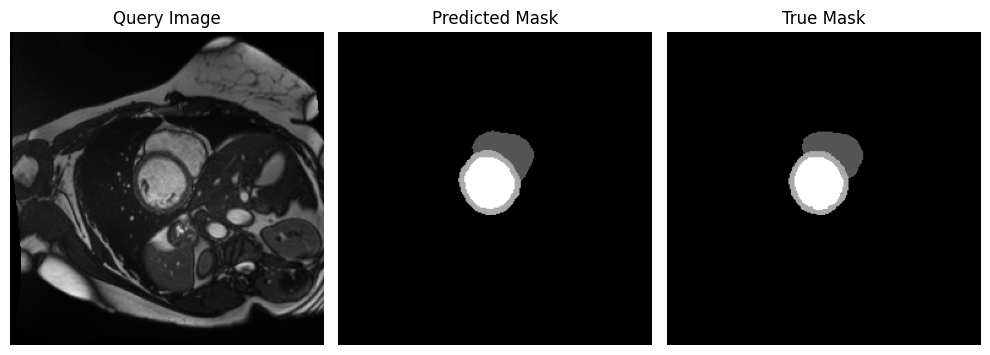

In [29]:
show_prediction(test_image, prediction,test_mask)

In [26]:
import torch
import torch.nn.functional as F

def predict_on_dataloader(
    model,
    dataloader: torch.utils.data.DataLoader,
    device: torch.device
):
    """
    Runs batch-wise inference on all data from a given DataLoader,
    using the retrieval + segmentation pipeline.

    Args:
        model: Your JointTrainingModule that has cached gallery embeddings/images/masks
               already set on .cached_gallery_embeddings, .cached_gallery_images, .cached_gallery_masks
        dataloader: A PyTorch DataLoader that yields (images[, labels]) 
                    where `images` is shape (B,3,H,W).
        device: torch device (e.g., torch.device("cuda")).

    Returns:
        all_pred_masks: A list of torch.Tensor objects, each shape (H, W) for each sample.
                        Or shape (B, H, W) per batch if you prefer. Below we flatten them.
    """
    model.eval()
    all_pred_masks = []
    all_gt_masks = []
    all_img = []

    with torch.no_grad():
        for batch_data in tqdm(dataloader):
            query_images, query_masks = batch_data  # ignoring ground truth for inference
        
            # Move to device => (B,3,H,W)
            query_images = query_images.to(device)

            # 1) Compute query embeddings => (B,D)
            query_embedding = model.retrieval_model(query_images)

            similarity = F.cosine_similarity(query_embedding.unsqueeze(1), model.cached_gallery_embeddings.unsqueeze(0), dim=-1)
    
            # -- 2) Get indices and values of the top 2 most similar gallery items
            topk_values, topk_indices = torch.topk(similarity, k=2, dim=-1)
    
            tau=0.1
            # -- 3) Calculate softmax weights for the top 2 values
            softmax_weights = F.softmax(topk_values / tau, dim=-1)
    
            # -- 4) Create a zero tensor for the top-k weights
            topk_weights = torch.zeros_like(similarity).float()
    
            # -- 5) Scatter the softmax weights into the top-k weights at the correct indices
            topk_weights.scatter_(dim=-1, index=topk_indices, src=softmax_weights)
    
            # -- 6) Weighted sum of the top 2 gallery images and masks
            # guide_image: (B, 3, H, W)
            guide_image = torch.einsum("bn,nchw->bchw", topk_weights, model.cached_gallery_images)
            # guide_mask: (B, H, W)
            guide_mask = torch.einsum("bn,nhw->bhw", topk_weights, model.cached_gallery_masks.float())

            # 5) Composite input => (B, 7, H, W)
            # 3 channels query, 3 channels guide, 1 channel guide_mask
            composite_input = torch.cat([
                query_images,         # (B,3,H,W)
                guide_image,          # (B,3,H,W)
                guide_mask.unsqueeze(1)  # (B,1,H,W)
            ], dim=1)

            # 6) Forward pass in segmentation model => (B, num_classes, H, W)
            pred_logits = model.segmentation_model(composite_input)

            # Convert to float and argmax => (B,H,W)
            pred_logits = pred_logits.float()
            pred_mask = torch.argmax(pred_logits, dim=1)

            for b in range(pred_mask.shape[0]):
                all_pred_masks.append(pred_mask[b].cpu())
                all_gt_masks.append(query_masks[b])
                all_img.append(query_images[b].cpu())

    return all_pred_masks, all_gt_masks, all_img


In [27]:
predictions, all_gt_masks, all_img = predict_on_dataloader(joint_module, test_loader, device)
print(f"Got {len(predictions)} predictions total.")

100%|██████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:23<00:00, 10.66it/s]

Got 1001 predictions total.


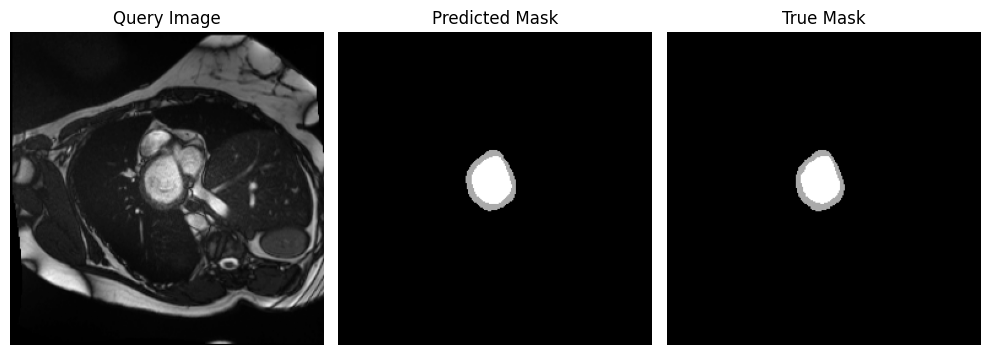

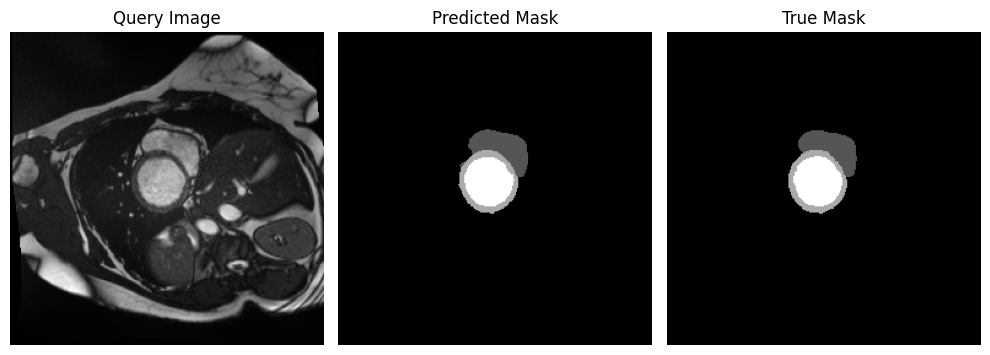

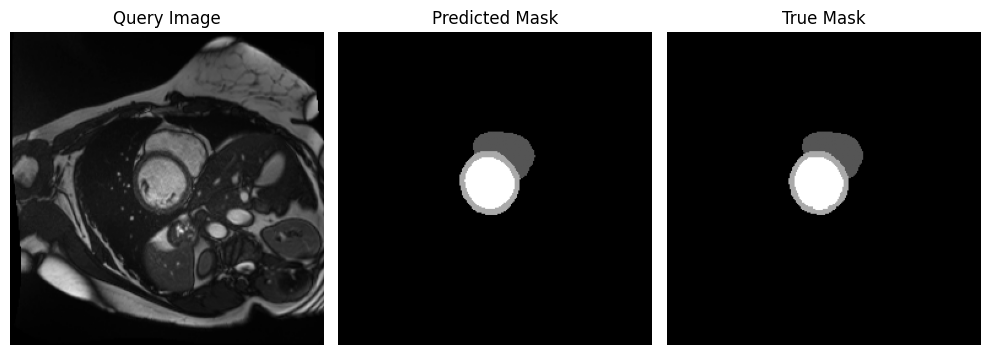

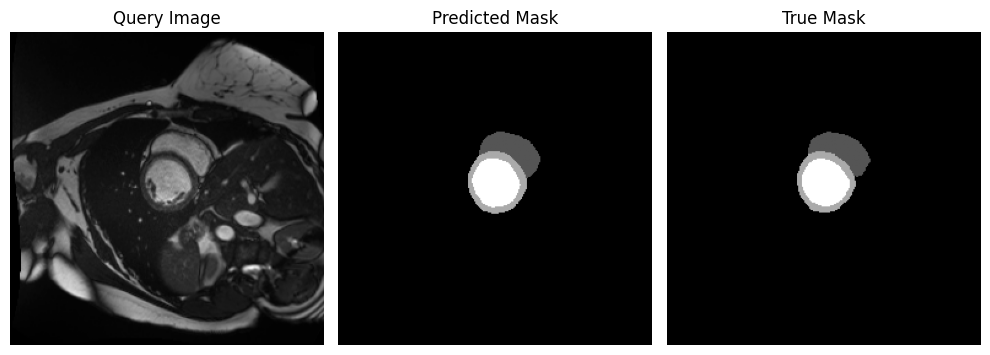

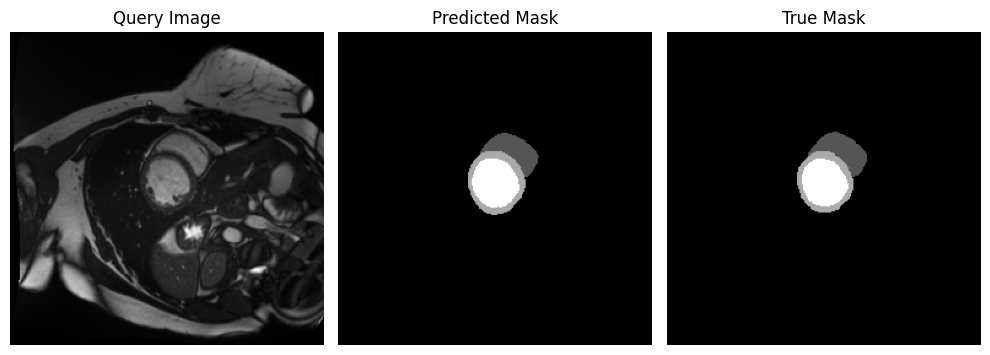

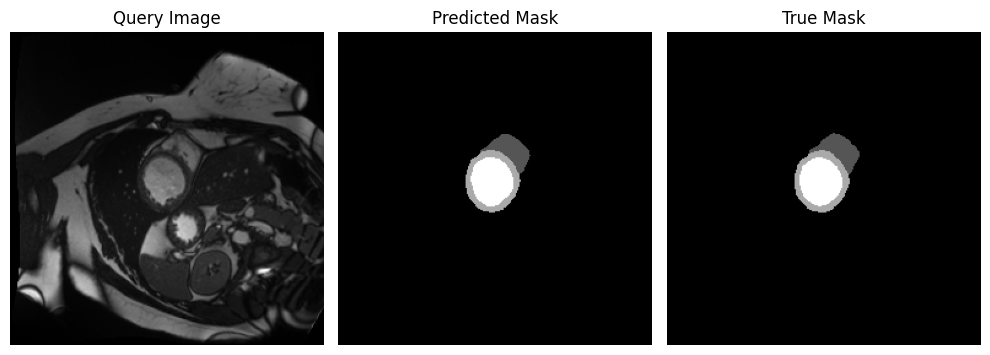

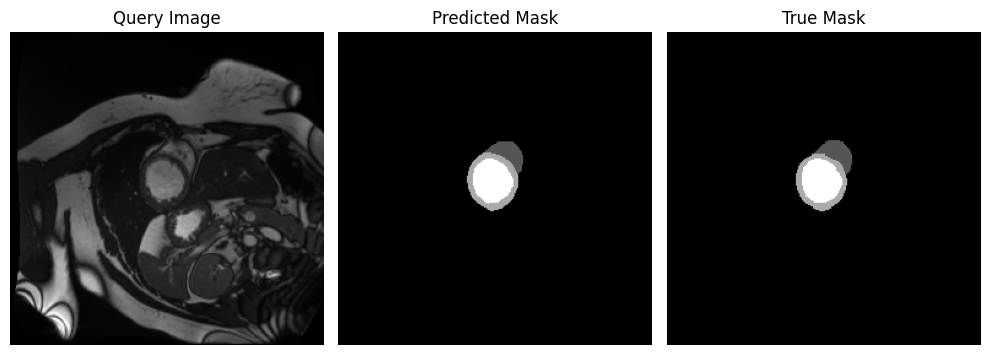

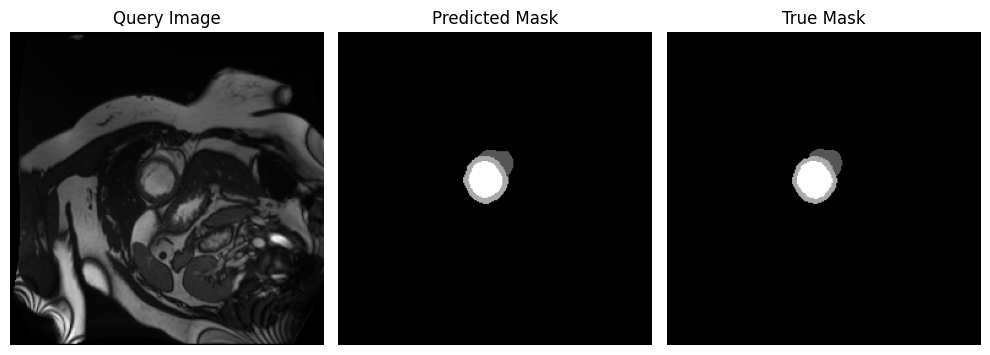

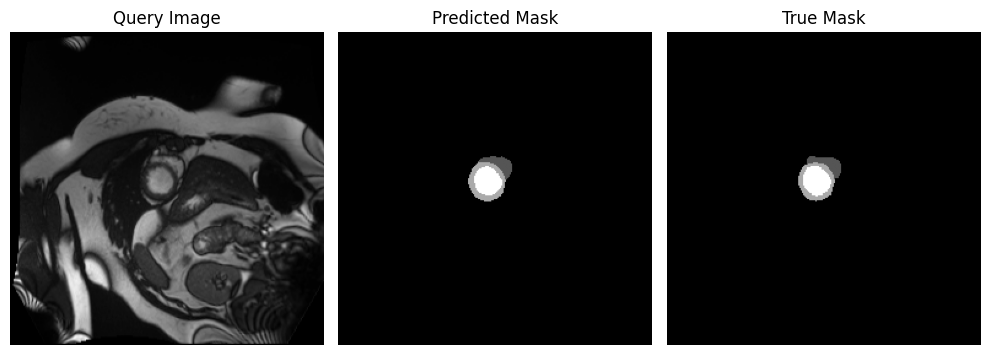

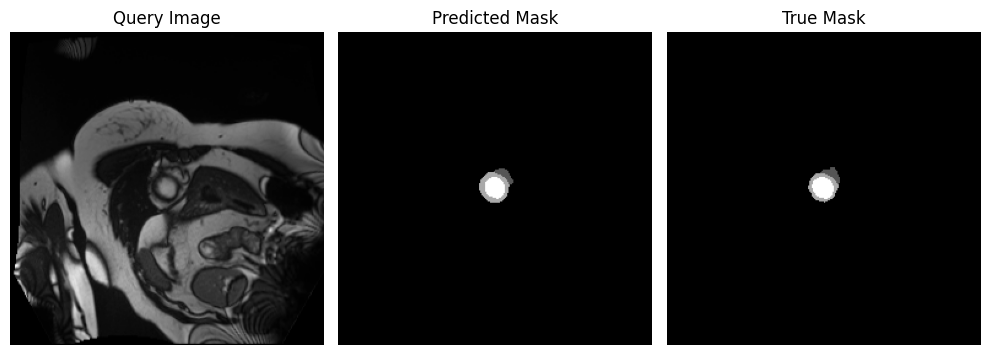

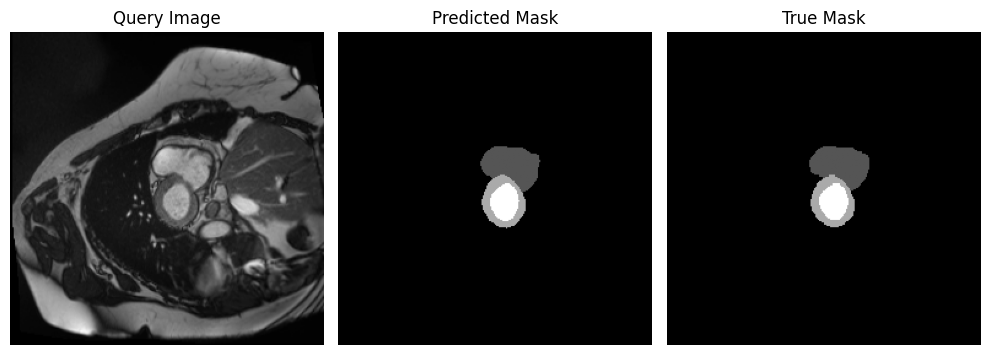

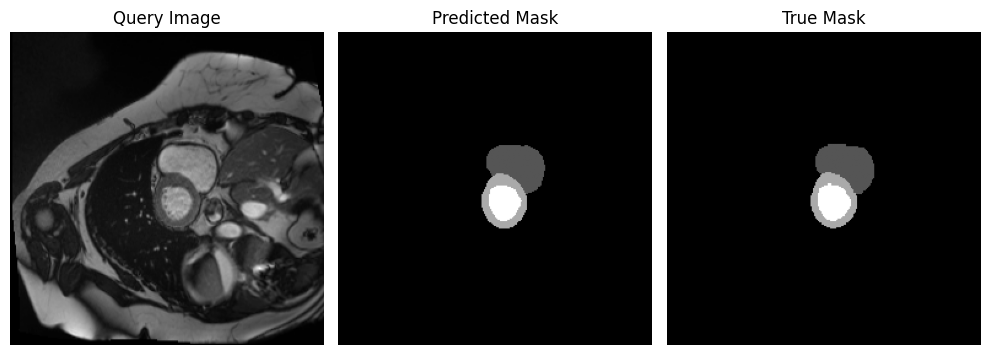

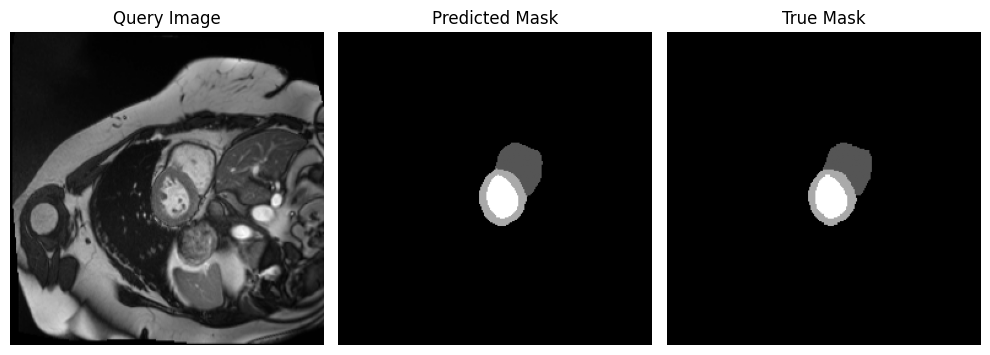

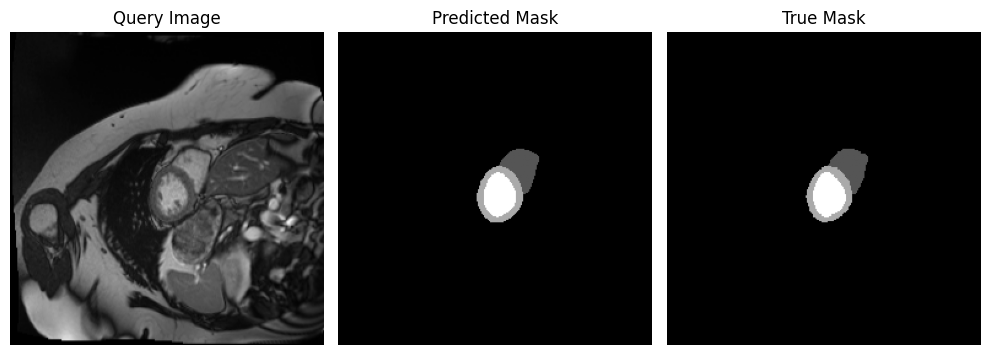

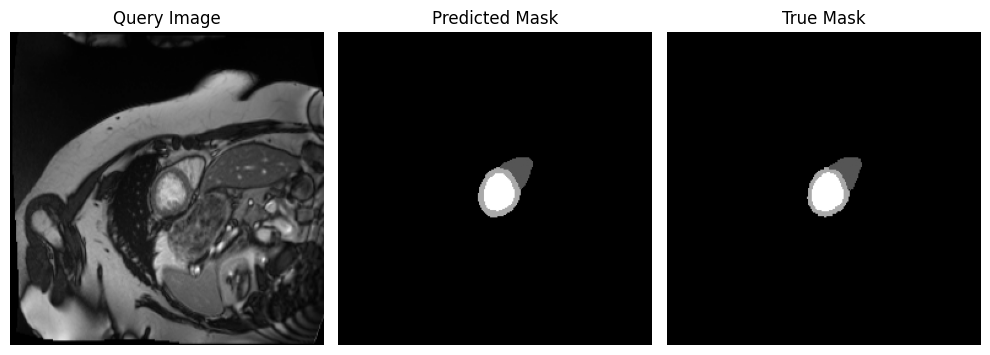

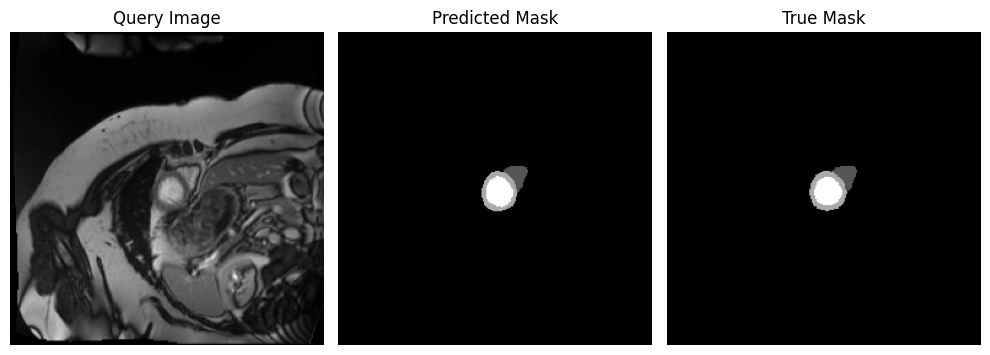

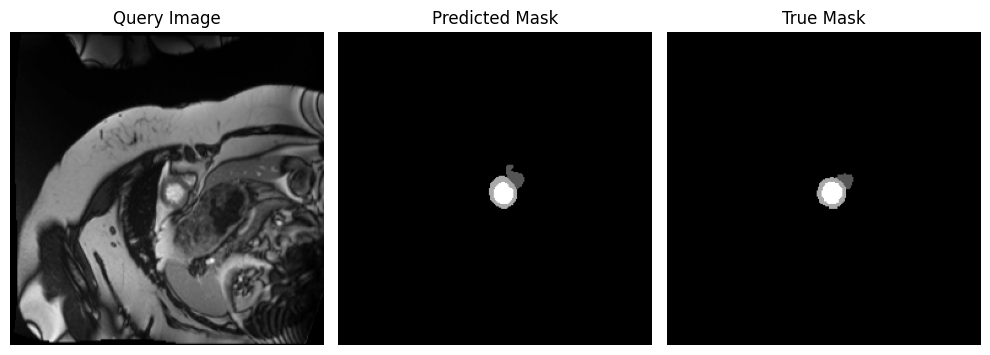

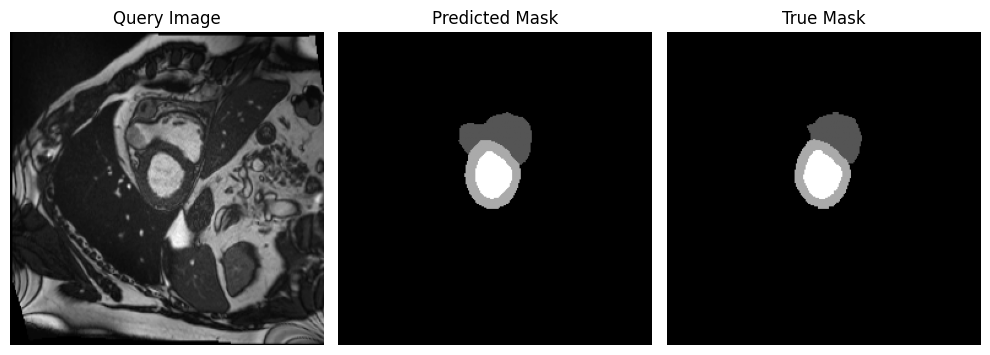

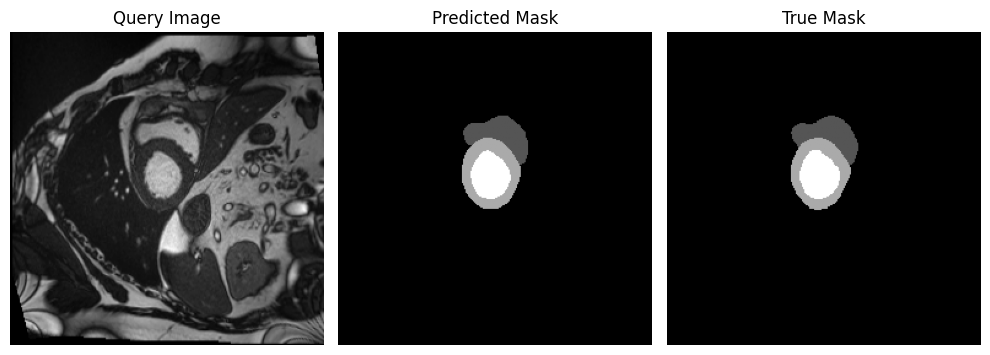

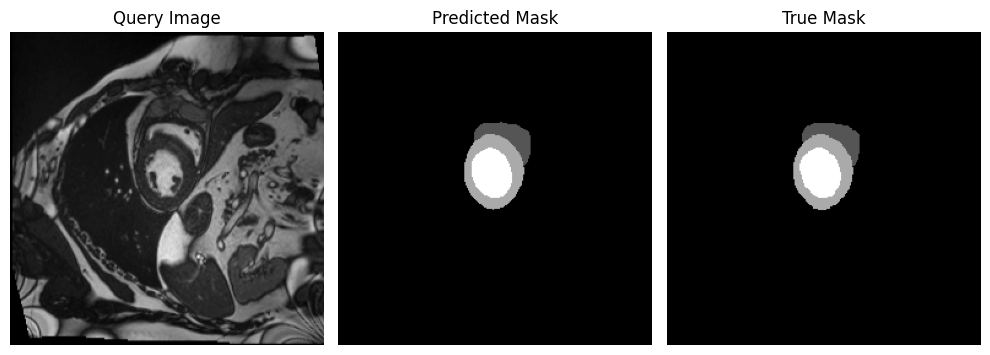

In [28]:
for i in range(20):
    show_prediction(all_img[i], predictions[i],all_gt_masks[i])

In [33]:
import torch

def compute_metrics_single(pred_mask: torch.Tensor, gt_mask: torch.Tensor, num_classes: int, smooth: float = 1e-6):
    dice_per_class = []
    iou_per_class = []
    for c in range(num_classes):
        # Create binary masks for class c
        pred_c = (pred_mask == c).float()
        gt_c = (gt_mask == c).float()
        
        # Calculate intersection and union for Dice
        intersection = torch.sum(pred_c * gt_c)
        union_dice = torch.sum(pred_c) + torch.sum(gt_c)
        dice_score = (2 * intersection + smooth) / (union_dice + smooth)
        dice_per_class.append(dice_score)
        
        # Calculate union for IoU (intersection over union)
        union_iou = torch.sum(pred_c) + torch.sum(gt_c) - intersection
        iou_score = (intersection + smooth) / (union_iou + smooth)
        iou_per_class.append(iou_score)
    
    dice_per_class = torch.stack(dice_per_class)
    iou_per_class = torch.stack(iou_per_class)
    mean_dice = dice_per_class.mean().item()
    mean_iou  = iou_per_class.mean().item()
    return dice_per_class, iou_per_class, mean_dice, mean_iou

num_classes = 4
mean_dice_lists, mean_iou_lists = [], []

for pred, gt in zip(predictions, all_gt_masks):
    _, _, dice, iou = compute_metrics_single(pred, gt, num_classes)
    mean_dice_lists.append(dice)
    mean_iou_lists.append(iou)
print(f"Mean Dice: {sum(mean_dice_lists) / len(mean_dice_lists)}\nMean IOU: {sum(mean_iou_lists) / len(mean_iou_lists)}")

Mean Dice: 0.8782858749131461
Mean IOU: 0.8283444260443364


In [37]:
import torch

def compute_multiclass_dice_iou(preds, gts, num_classes=4, smooth=1e-6):
    """
    preds: list of predicted masks, each of shape (H, W) with class indices
    gts: list of ground truth masks, each of shape (H, W) with class indices
    num_classes: total number of segmentation classes
    """
    dice_per_class = [0.0] * num_classes
    iou_per_class = [0.0] * num_classes
    count_per_class = [0] * num_classes  # For averaging only over present classes

    for pred, gt in zip(preds, gts):
        for cls in range(num_classes):
            pred_cls = (pred == cls).float()
            gt_cls = (gt == cls).float()

            intersection = torch.sum(pred_cls * gt_cls)
            union_dice = torch.sum(pred_cls) + torch.sum(gt_cls)
            union_iou = torch.sum(pred_cls) + torch.sum(gt_cls) - intersection

            if torch.sum(gt_cls) > 0 or torch.sum(pred_cls) > 0:
                dice = (2 * intersection + smooth) / (union_dice + smooth)
                iou = (intersection + smooth) / (union_iou + smooth)

                dice_per_class[cls] += dice.item()
                iou_per_class[cls] += iou.item()
                count_per_class[cls] += 1

    # Average only over images where the class was present
    final_dice = [d / c if c > 0 else 0.0 for d, c in zip(dice_per_class, count_per_class)]
    final_iou = [i / c if c > 0 else 0.0 for i, c in zip(iou_per_class, count_per_class)]

    return final_dice, final_iou


In [40]:
# predictions and ground_truths are lists of tensors with shape [256, 256]
dice_scores, iou_scores = compute_multiclass_dice_iou(predictions, all_gt_masks, num_classes=4)

# Print per-class metrics
for i, (d, iou) in enumerate(zip(dice_scores, iou_scores)):
    print(f"Class {i}: Dice = {d:.4f}, IoU = {iou:.4f}")

# Optionally compute the mean across all classes
mean_dice = sum(dice_scores) / len(dice_scores)
mean_iou = sum(iou_scores) / len(iou_scores)
print(f"\nMean Dice Score: {mean_dice:.4f}")
print(f"Mean IoU Score: {mean_iou:.4f}")


Class 0: Dice = 0.9977, IoU = 0.9954
Class 1: Dice = 0.7850, IoU = 0.7206
Class 2: Dice = 0.8235, IoU = 0.7403
Class 3: Dice = 0.8959, IoU = 0.8426

Mean Dice Score: 0.8755
Mean IoU Score: 0.8247


In [36]:
pred_tensor = torch.stack(predictions).to(device)
gt_tensor = torch.stack(all_gt_masks).to(device)

In [48]:
from torchmetrics.segmentation import DiceScore

dice_score = DiceScore(num_classes=4,include_background=True, average="macro",input_format='index')

dice_score(pred_tensor, gt_tensor)

tensor(0.8839, device='cuda:0')

In [ ]:
# 0.7732 Right Ventricle (RV)   0.6729
# 0.8506    Myocardium.          0.7757
# 0.9150  Left Ventricle (LV).   0.8472

In [49]:
from torchmetrics.functional.segmentation import dice_score

dice_score(pred_tensor, gt_tensor, num_classes=4, input_format="index" ,average="macro").mean()

tensor(0.9033, device='cuda:0')

In [51]:
from torchmetrics.segmentation import MeanIoU

miou = MeanIoU(num_classes=4,per_class=True,input_format='index',include_background =True).to(device)

miou(pred_tensor, gt_tensor)

tensor([0.9966, 0.7211, 0.7850, 0.8723], device='cuda:0')

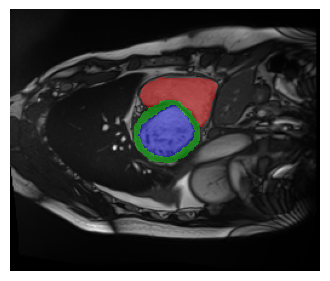

In [84]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load the image
image_path = "../datasets/ACDC/processed_data/Training/ed/images/patient001_frame01_slice_1.png"
mask_path = "../datasets/ACDC/processed_data/Training/ed/masks/patient001_frame01_gt_slice_1_gt.png"

image = Image.open(image_path).convert('RGB')
mask = Image.open(mask_path)

# Convert mask to numpy array
mask_np = remap_labels(torch.tensor(np.array(mask))).numpy()

# Define color map for each class (assuming classes 0,1,2,3)
colors = np.array([
    [0, 0, 0, 0],           # class 0: transparent (background)
    [255, 0, 0, 100],       # class 1: red    Right Ventricle (RV)
    [0, 255, 0, 100],       # class 2: green.  Myocardium
    [0, 0, 255, 100],       # class 3: blue.  Left Ventricle (LV)
], dtype=np.uint8)

# Create a color overlay mask
overlay = np.zeros((mask_np.shape[0], mask_np.shape[1], 4), dtype=np.uint8)
for class_id in range(1, 4):  # skip background (0)
    overlay[mask_np == class_id] = colors[class_id]

# Plotting the image with mask overlay
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.imshow(overlay, cmap='jet', interpolation='none')
plt.axis('off')
# plt.title("Image with Mask Overlay")
plt.show()


In [161]:
# import torch
# import torch.nn.functional as F
# import torchvision.transforms as T
# from PIL import Image

# # 0) Rebuild your retrieval and segmentation submodels, then your Joint module (like in training)
# retrieval_model = SimCLR(dropout_p=0.3, embedding_size=128, linear_eval=True)
# segformer_base  = SegformerForSemanticSegmentation(config)
# segformer_model = JointSegmentationModel(segformer_base, composite_in_channels=7)
# joint_model = JointTrainingModule(
#     retrieval_model, 
#     segformer_model, 
#     num_classes=4, 
#     lr=1e-4, 
#     tau=0.1
# )

# # 1) Load checkpoint
# checkpoint_path = "/path/to/best_checkpoint_epoch_X.pth"
# ckpt = torch.load(checkpoint_path, map_location="cpu")
# joint_model.load_state_dict(ckpt["model_state_dict"], strict=True)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# joint_model.to(device)
# joint_model.eval()

# # 2) Precompute gallery embeddings
# # Suppose you already have gallery_images (N, 3, 256, 256) / gallery_masks (N, 256, 256) in memory or loaded
# with torch.no_grad():
#     gallery_embs, gallery_imgs, gallery_msks = precompute_gallery_embeddings(
#         joint_model, gallery_images, gallery_masks, device
#     )
    
# joint_model.cached_gallery_embeddings = gallery_embs
# joint_model.cached_gallery_images     = gallery_imgs
# joint_model.cached_gallery_masks      = gallery_msks

# # 3) Define a function to read/transform the test image
# def read_test_image(image_path: str) -> torch.Tensor:
#     img = Image.open(image_path).convert("RGB")
#     transform = T.Compose([T.Resize((256, 256)), T.ToTensor()])
#     return transform(img)  # => shape (3,256,256)

# # 4) Define or reuse the `predict` function from above
# def predict(model, query_image: torch.Tensor, device: torch.device) -> torch.Tensor:
#     model.eval()
#     with torch.no_grad():
#         if query_image.ndim == 3:
#             query_image = query_image.unsqueeze(0)
#         query_image = query_image.to(device)

#         query_embedding = model.retrieval_model(query_image)
#         similarity = F.cosine_similarity(
#             query_embedding.unsqueeze(1),
#             model.cached_gallery_embeddings.unsqueeze(0),
#             dim=-1
#         )
#         weights = F.softmax(similarity / model.tau, dim=-1)
#         guide_image = torch.einsum("bn,nchw->bchw", weights, model.cached_gallery_images)
#         guide_mask  = torch.einsum("bn,nhw->bhw",   weights, model.cached_gallery_masks.float())

#         composite_input = torch.cat([
#             query_image, 
#             guide_image, 
#             guide_mask.unsqueeze(1)
#         ], dim=1)
#         pred_logits = model.segmentation_model(composite_input)
#         pred_logits = pred_logits.float()
#         pred_mask = torch.argmax(pred_logits, dim=1)
#     return pred_mask.squeeze(0)

# # 5) Inference on a test image
# test_image_path = "/path/to/test_image.png"
# test_image = read_test_image(test_image_path)
# pred_mask = predict(joint_model, test_image, device)  # => (256,256)
# print(pred_mask.shape)


# predict

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import Dinov2Model, SegformerForSemanticSegmentation
from safetensors.torch import load_file
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.checkpoint import checkpoint as torch_checkpoint
from torchmetrics import MeanMetric
from PIL import Image
import os
import numpy as np
from dataclasses import dataclass
import random
from tqdm import tqdm
import time
import wandb
import cv2

In [2]:
class JointSegmentationModel(nn.Module):
    def __init__(self, base_model, composite_in_channels=7):
        super().__init__()
        # Map composite input channels to 3 channels expected by segformer
        self.input_adapter = nn.Conv2d(composite_in_channels, 3, kernel_size=1)
        self.base_model = base_model

    def forward(self, x):
        x = self.input_adapter(x)
        outputs = self.base_model(pixel_values=x, return_dict=True)
        # Upsample logits to match input resolution
        logits = F.interpolate(outputs["logits"], size=x.shape[-2:], mode="bilinear", align_corners=False)
        return logits

def dice_coef_loss(predictions, ground_truths, num_classes=4, dims=(1, 2), smooth=1e-8):
    ground_truth_oh = F.one_hot(ground_truths, num_classes=num_classes)
    prediction_norm = F.softmax(predictions, dim=1).permute(0, 2, 3, 1)
    intersection = (prediction_norm * ground_truth_oh).sum(dim=dims)
    summation = prediction_norm.sum(dim=dims) + ground_truth_oh.sum(dim=dims)
    dice = (2.0 * intersection + smooth) / (summation + smooth)
    dice_mean = dice.mean()
    CE = F.cross_entropy(predictions, ground_truths)
    return (1.0 - dice_mean) + CE

def differentiable_top2(similarity, tau=1.0):
    weights1 = F.gumbel_softmax(similarity, tau=tau, hard=True)
    B, N = similarity.shape
    masked_similarity = similarity.clone()
    indices = weights1.argmax(dim=-1, keepdim=True)
    for i in range(B):
        masked_similarity[i, indices[i]] = float('-inf')
    weights2 = F.gumbel_softmax(masked_similarity, tau=tau, hard=True)
    return weights1, weights2

In [3]:
# ----------------------------
# Segmentation Model Setup
# ----------------------------
ckpt_path = '/scratch/saahmed/projects/Image-segmentation/segmentation/lightning_logs/version_0/checkpoints/ckpt_053-vloss_0.1769_vf1_0.9259.ckpt'
checkpoint = torch.load(ckpt_path, map_location="cuda:0")
state_dict = checkpoint["state_dict"]
new_state_dict = {key.replace("model.", ""): value for key, value in state_dict.items()}
config = SegformerForSemanticSegmentation.config_class.from_pretrained("nvidia/segformer-b4-finetuned-ade-512-512")
config.num_labels = 4
segformer_base = SegformerForSemanticSegmentation(config)
segformer_base.load_state_dict(new_state_dict)
segmentation_model = JointSegmentationModel(segformer_base, composite_in_channels=7)


/tmp/ipykernel_3718819/524647098.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location="cuda:0")


In [4]:
# ----------------------------
# Model Definitions
# ----------------------------

class SimCLR(nn.Module):
    def __init__(self, dropout_p=0.5, embedding_size=128, freeze=False, linear_eval=False):
        super().__init__()
        self.linear_eval = linear_eval
        self.dropout_p = dropout_p
        self.embedding_size = embedding_size
        self.encoder = Dinov2Model.from_pretrained('microsoft/rad-dino')
        
        if freeze:
            for param in self.encoder.parameters():
                param.requires_grad = False

        self.projection = nn.Sequential(
            nn.Linear(768, 256),
            nn.Dropout(p=self.dropout_p),
            nn.ReLU(),
            nn.Linear(256, embedding_size)
        )

    def forward(self, x):
        if not self.linear_eval:
            x = torch.cat(x, dim=0)
        outputs = self.encoder(x)
        encoding = outputs.last_hidden_state[:, 0]
        projection = self.projection(encoding)
        return projection

retrieval_checkpoint = '/home/saahmed/scratch/projects/Image-segmentation/retrieval/checkpoints/simclr_rad-dino_pos-pairs_aug-pairs_epochs100/best_model/'

retrieval_model = SimCLR(dropout_p=0.3, embedding_size=128, freeze=False, linear_eval=True)
encoder_state_dict = load_file(os.path.join(retrieval_checkpoint, 'model.safetensors'))
retrieval_model.encoder.load_state_dict(encoder_state_dict)
projection_state_dict = torch.load(os.path.join(retrieval_checkpoint, 'projection_head.pth'), map_location=torch.device('cpu'))
retrieval_model.projection.load_state_dict(projection_state_dict)

/tmp/ipykernel_3718819/2775795213.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  projection_state_dict = torch.load(os.path.join(retrieval_checkpoint, 'projection_head

<All keys matched successfully>

In [5]:
class JointTrainingModule(nn.Module):
    def __init__(self, retrieval_model, segmentation_model, num_classes=4, lr=1e-4):
        super().__init__()
        self.retrieval_model = retrieval_model
        self.segmentation_model = segmentation_model
        self.lr = lr
        self.num_classes = num_classes

    def forward(self, query_image, gallery_images, gallery_masks):
        # Compute query embedding
        query_embedding = self.retrieval_model(query_image)
        B, N, C, H, W = gallery_images.shape
        gallery_images_flat = gallery_images.view(B * N, C, H, W)

        gallery_embeddings_list = []
        
        def compute_embedding(x):
            return self.retrieval_model(x)
        
        print('Calculating Embeddings')
        start_time = time.time()
        tempbatch_size = 70
        for i in range(0, B * N, tempbatch_size):
            batch = gallery_images_flat[i:i + tempbatch_size]
            emb = torch_checkpoint(compute_embedding, batch, use_reentrant=False)
            # emb = self.retrieval_model(batch)
            gallery_embeddings_list.append(emb)
        print('Finished Calculating Embeddings')
        
        gallery_embeddings_flat = torch.cat(gallery_embeddings_list, dim=0)
        emb_dim = gallery_embeddings_flat.shape[1]
        gallery_embeddings = gallery_embeddings_flat.view(B, N, emb_dim)
        end_time = time.time()
        print(f"Calculating Embeddings Time: {end_time - start_time:.4f} seconds\n")


        
        print('Calculating similarity')
        start_time = time.time()
        similarity = F.cosine_similarity(query_embedding.unsqueeze(1), gallery_embeddings, dim=-1)
        end_time = time.time()
        print('Finished Calculating similarity')
        print(f"Calculating similarity Time: {end_time - start_time:.4f} seconds\n")
        

        print('Calculating differentiable top2')
        start_time = time.time()
        weights1, weights2 = differentiable_top2(similarity, tau=1.0)
        end_time = time.time()
        print('Finished Calculating differentiable top2')
        print(f"Calculating differentiable top2 Time: {end_time - start_time:.4f} seconds\n")
        

        print('Calculating einsum')
        start_time = time.time()
        guide_image1 = torch.einsum('bn,bnchw->bchw', weights1, gallery_images)
        guide_image2 = torch.einsum('bn,bnchw->bchw', weights2, gallery_images)
        guide_mask1 = torch.einsum('bn,bnhw->bhw', weights1, gallery_masks.float())
        guide_mask2 = torch.einsum('bn,bnhw->bhw', weights2, gallery_masks.float())
        end_time = time.time()
        print('Finished Calculating einsum')
        print(f"Calculating einsum Time: {end_time - start_time:.4f} seconds\n")
        return guide_image1, guide_image2, guide_mask1, guide_mask2

In [ ]:
# Load the checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load("../../../best_checkpoint_epoch_1.pth", map_location=device)

# Recreate your model architecture (if not already available)
joint_module = JointTrainingModule(retrieval_model, segmentation_model, num_classes=4, lr=1e-4)
joint_module.load_state_dict(checkpoint["model_state_dict"])
joint_module.to(device)
joint_module.eval()

In [7]:
def convert_to_rgb(img):
    return img.convert("RGB")
    
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Lambda(convert_to_rgb),
    transforms.ToTensor(),
])

def remap_labels(target, mapping={0: 0, 85: 1, 170: 2, 255: 3}):
    remapped_target = torch.zeros_like(target, dtype=torch.long)
    for original_label, new_label in mapping.items():
        remapped_target[target == original_label] = new_label
    return remapped_target

In [12]:
all_images_path_ed = "../datasets/ACDC/processed_data/Training/ed/images/"
all_images_path_es = "../datasets/ACDC/processed_data/Training/es/images/"

all_masks_path_ed = "../datasets/ACDC/processed_data/Training/ed/masks/"
all_masks_path_es = "../datasets/ACDC/processed_data/Training/es/masks/"

all_images_paths_ed = sorted([all_images_path_ed+i for i in os.listdir(all_images_path_ed)])
all_images_paths_es = sorted([all_images_path_es+i for i in os.listdir(all_images_path_es)])

all_masks_paths_ed = sorted([all_masks_path_ed+i for i in os.listdir(all_masks_path_ed)])
all_masks_paths_es = sorted([all_masks_path_es+i for i in os.listdir(all_masks_path_es)])

In [13]:
all_images_paths = all_images_paths_ed + all_images_paths_es
all_masks_paths = all_masks_paths_ed + all_masks_paths_es

In [17]:
def is_mask_empty(mask):
    return np.all(mask == 255)

In [18]:
valid_images = []
valid_masks = []
for img_path, mask_path in tqdm(zip(all_images_paths, all_masks_paths), total=len(all_images_paths)):
    if not os.path.exists(mask_path):
        continue
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        continue
    if is_mask_empty(mask):
        continue
    valid_images.append(img_path)
    valid_masks.append(mask_path)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1902/1902 [00:07<00:00, 249.55it/s]


In [20]:
len(valid_images)

1841

In [40]:
embeddings_calc = []
for img in tqdm(valid_images):
    img_ = Image.open(img)
    img_tensor = preprocess(img_)
    with torch.no_grad():  # Disables gradient calculation, reducing memory usage
        img_embedding = joint_module.retrieval_model(img_tensor.unsqueeze(0).to(device))
    embeddings_calc.append(img_embedding.cpu().numpy()) 
    torch.cuda.empty_cache()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1841/1841 [00:30<00:00, 60.34it/s]


In [135]:
query_image_path = all_images_paths[400]
query_img = Image.open(query_image_path)
query_tensor = preprocess(query_img)  # using your defined preprocess transform
with torch.no_grad():
    query_embedding = joint_module.retrieval_model(query_tensor.unsqueeze(0).to(device))

In [136]:
from sklearn.metrics.pairwise import cosine_similarity

In [137]:
query_embedding = query_embedding.cpu().numpy()  # Convert to numpy array

# Compute cosine similarity between the query embedding and each image embedding
similarities = cosine_similarity(query_embedding, np.vstack(embeddings_calc))

# Get the indices of the most similar images
most_similar_indices = np.argsort(similarities[0])[::-1]  # Sort in descending order

# If you want the top N most similar images
top_n = 5  # Specify how many top similar images you want
top_n_similar_images = [valid_images[idx] for idx in most_similar_indices[:top_n]]

# Display the most similar images
for img_path in top_n_similar_images:
    print(f"Most similar image: {img_path}")

Most similar image: ../datasets/ACDC/processed_data/Training/ed/images/patient043_frame01_slice_1.png
Most similar image: ../datasets/ACDC/processed_data/Training/ed/images/patient043_frame01_slice_0.png
Most similar image: ../datasets/ACDC/processed_data/Training/es/images/patient043_frame07_slice_2.png
Most similar image: ../datasets/ACDC/processed_data/Training/es/images/patient043_frame07_slice_0.png
Most similar image: ../datasets/ACDC/processed_data/Training/ed/images/patient043_frame01_slice_2.png


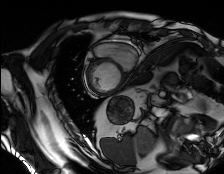

In [138]:
Image.open(query_image_path)

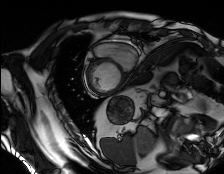

In [139]:
Image.open(top_n_similar_images[0])

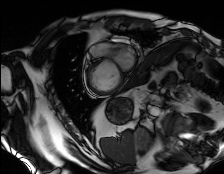

In [140]:
Image.open(top_n_similar_images[1])

In [141]:
similar_images_tensors = []
for path in top_n_similar_images[:2]:
    img = Image.open(path)
    similar_images_tensors.append(preprocess(img))
similar_images_tensors = torch.stack(similar_images_tensors, dim=0)  # shape: (N, 3, H, W)


top_n_similar_images_masks = [valid_masks[idx] for idx in most_similar_indices[:top_n]]

mask_tensors = []
for path in top_n_similar_images_masks[:2]:
    mask = Image.open(path).convert('L')  # assume grayscale masks
    mask = mask.resize((256, 256), resample=Image.NEAREST)
    mask_tensor = torch.from_numpy(np.array(mask)).long()
    mask_tensor = remap_labels(mask_tensor)  # using your remap_labels function
    mask_tensors.append(mask_tensor)
mask_tensors = torch.stack(mask_tensors, dim=0)  # shape: (N, H, W)


In [142]:
g1 = similar_images_tensors[0].unsqueeze(0)
g1 = similar_images_tensors[0].unsqueeze(0)

g_m1 = mask_tensors[0].unsqueeze(0)  
g_m2 = mask_tensors[0].unsqueeze(0) 

In [146]:
with torch.no_grad():
    # guide_image1, guide_image2, guide_mask1, guide_mask2 = joint_module(query_image, gallery_images, gallery_masks)
    composite_input = torch.cat([
        query_image.to(device),
        g1.to(device),
        g2.to(device),
        g_m1.unsqueeze(1).to(device),
        g_m2.unsqueeze(1).to(device),
    ], dim=1)
    
    pred_masks = segmentation_model(composite_input)
    pred_masks = torch.argmax(pred_masks, dim=1, keepdim=False)
    pred_masks = pred_masks.cpu().numpy()

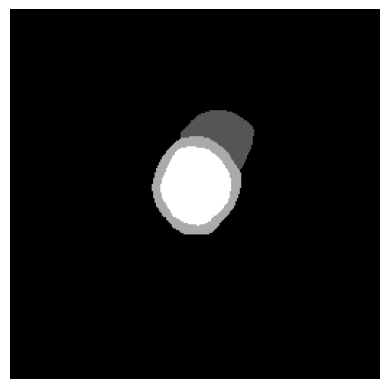

In [144]:
import matplotlib.pyplot as plt

# Assuming pred_masks is already a NumPy array of shape (256, 256)
plt.imshow(pred_masks.squeeze(0), cmap='gray')
plt.axis(False)
plt.show()


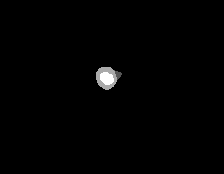

In [145]:
Image.open(valid_masks[valid_images.index(query_image_path)])